In [1]:
base_dir = 'C:\\Projects\\ature'
import os
os.chdir(base_dir) #BASE DIRECTORY

### DRIVE dataset
data_file_path = 'data\\DRIVE\\test\\images'
mask_path = 'data\\DRIVE\\test\\mask'
ground_truth_path = 'data\\DRIVE\\test\\1st_manual'
mask_suffix =  '_test_mask.gif'
ground_truth_suffix = '_manual1.gif'

input_image = '19_test.tif'

In [2]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
import sys
import numpy as np
import itertools as itr
from random import shuffle
from commons.segmentation import AtureTest
from PIL import Image as IMG
from commons.IMAGE import SegmentedImage
import cv2
import preprocess.utils.filter_utils as filutils
import copy


SK_THRESHOLD_PARAMS = np.arange(40, 61, 20)
ALPHA_PARAMS = np.arange(5, 7, 0.5)
GABOR_CONTRIBUTION_PARAMS = np.arange(0.6, 1.1, 0.2)
SEGMENTATION_THRESHOLD_PARAMS = np.arange(9, 15, 0.5)

PARAMS_ITR = itr.product(SK_THRESHOLD_PARAMS, ALPHA_PARAMS, GABOR_CONTRIBUTION_PARAMS, SEGMENTATION_THRESHOLD_PARAMS)

PARAMS_COMBINATION = list(PARAMS_ITR)
shuffle(PARAMS_COMBINATION)

keys = ('sk_threshold', 'alpha', 'gabor_contrib', 'seg_threshold')

all_params = list(dict(zip(keys, param)) for param in PARAMS_COMBINATION)

params = {'sk_threshold': 60,
          'alpha': 8.0,
          'orig_contrib': 0.6,
          'seg_threshold': 25}

In [3]:
%load_ext autoreload
%autoreload 2

In [21]:
def get_mask_file(file_name): return file_name.split('_')[0] + mask_suffix
def get_ground_truth_file(file_name): return file_name.split('_')[0] + ground_truth_suffix

img_obj = SegmentedImage()

img_obj.load_file(data_dir=data_file_path, file_name=input_image)
img_obj.load_mask(mask_dir=mask_path, fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=ground_truth_path, fget_ground_truth=get_ground_truth_file)

img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
img_obj.working_arr = img_obj.image_arr[:, :, 1]

img_obj.apply_mask()
img_obj.apply_bilateral()
img_obj.apply_gabor()

img_obj.apply_bilateral()
img_obj.working_arr = img_obj.res['bilateral']
img_obj.apply_bilateral()
img_obj.working_arr = img_obj.res['bilateral']

img_obj.generate_skeleton(threshold=params['sk_threshold'])
IMG.fromarray(img_obj.res['skeleton']).show()
IMG.fromarray(img_obj.res['orig']).show()
IMG.fromarray(img_obj.res['gabor']).show()
IMG.fromarray(img_obj.working_arr).show()
img_obj.generate_lattice_graph()

Mask loaded: 19_test_mask.gif
Ground truth loaded: 19_manual1.gif
"apply_bilateral(__)" ... took 0.109 seconds
"apply_gabor(__)" ... took 1.078 seconds
"apply_bilateral(__)" ... took 0.103 seconds
"apply_bilateral(__)" ... took 0.125 seconds
"generate_skeleton(__)" ... took 0.002 seconds
"generate_lattice_graph(__)" ... took 2.941 seconds


In [5]:
### Run for image files with in-time mask erosion
tester = AtureTest(out_dir='out')
acc = tester.run(params=params, save_images=False, img_obj=img_obj)
# tester.run_all(params_combination=all_params)

"run_segmentation(__)" ... took 90.546 seconds
Number of params combination tried: 1


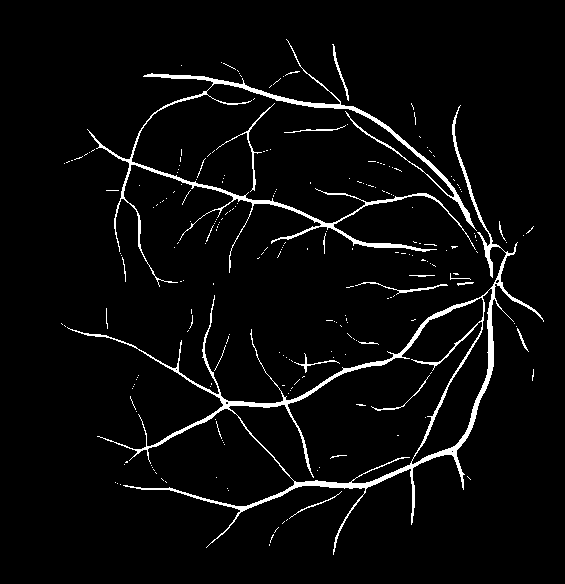

In [6]:
IMG.fromarray(img_obj.res['skeleton'])

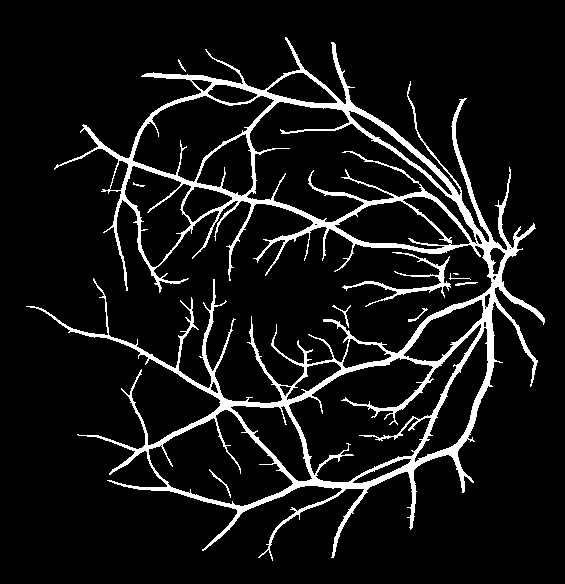

In [7]:
IMG.fromarray(img_obj.res['segmented'])

In [8]:
print(img_obj.res['scores'])

{'Precision': 0.8111905092271403, 'Recall': 0.8543714150012788, 'Accuracy': 0.971423808946539, 'F1': 0.8322212139006033}


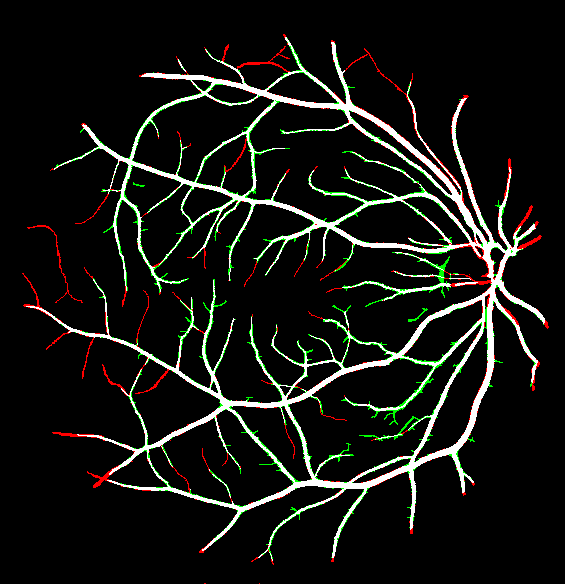

In [9]:
IMG.fromarray(img_obj.res['segmented_rgb'])

In [10]:
fni = np.full(img_obj.res['segmented'].shape, 250, dtype=np.uint8)
for i in range(fni.shape[0]):
    for j in range(fni.shape[1]):
        if img_obj.res['segmented'][i,j] == 0 and img_obj.ground_truth[i,j] == 255:
                       fni[i, j] = img_obj.res['gabor'][i, j]

In [11]:
m = img_obj.res['gabor'].copy()
for n1, n2 in img_obj.res['graph'].edges():
    m[n1] = 255
    m[n2] = 255

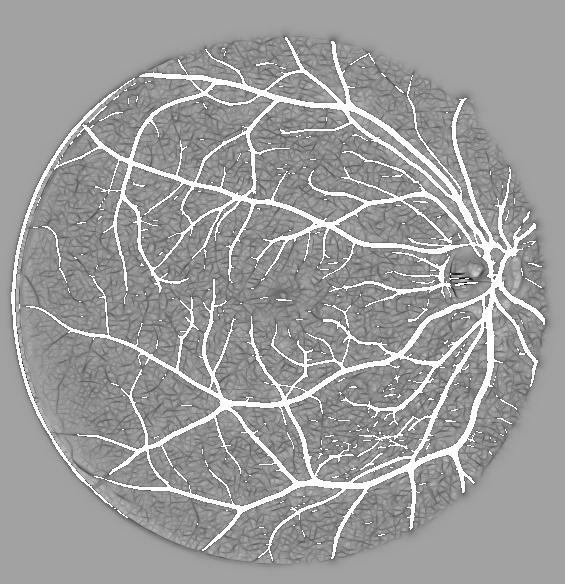

In [12]:
IMG.fromarray(m)

In [13]:
img = copy.deepcopy(img_obj)

In [14]:
img.apply_bilateral()

"apply_bilateral(__)" ... took 0.13 seconds


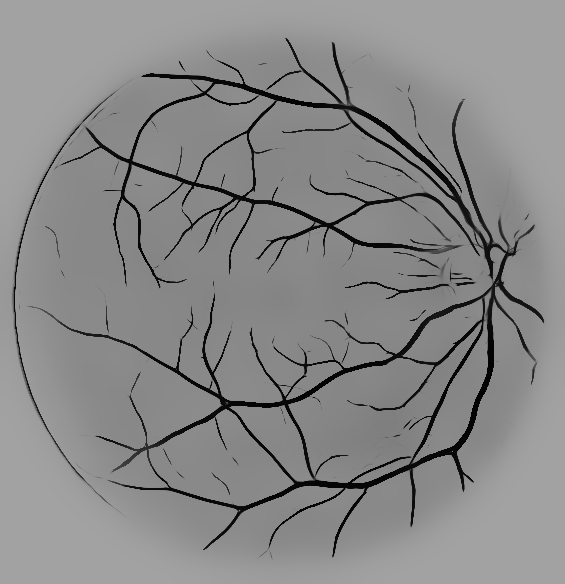

In [15]:
IMG.fromarray(img.res['bilateral'])

In [16]:
ig = SegmentedImage()

In [17]:
ig.working_arr = img_obj.res['gabor'][:,200:300]
ig.res['orig'] = img_obj.res['gabor'][:,200:300]

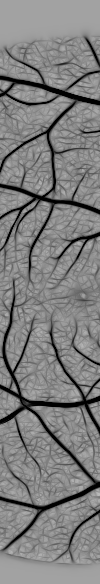

In [18]:
IMG.fromarray(ig.working_arr)

In [19]:
ig.ground_truth = img_obj.ground_truth[:,200:300]
ig.mask = img_obj.mask[:,200:300]
ig.apply_bilateral()
ig.generate_lattice_graph()

"apply_bilateral(__)" ... took 0.08 seconds
"generate_lattice_graph(__)" ... took 0.314 seconds


In [20]:
pms = {'sk_threshold': 80,
          'alpha': 15.0,
          'orig_contrib': 0.8,
          'seg_threshold': 25}
tester1 = AtureTest(out_dir='out')
a = tester.run(params=pms, save_images=False, img_obj=ig)

KeyError: 'skeleton'

In [ ]:
IMG.fromarray(ig.res['segmented_rgb'])

In [ ]:
# IMG.fromarray(img_obj.res['gabor'][:,200:300])
ig.working_arr = ig.res['bilateral']
ig.apply_bilateral()
IMG.fromarray(ig.res['bilateral'])

In [ ]:
img_obj.res['graph']

In [ ]:
cost = []
for n1,n2 in img_obj.res['graph'].edges():
    cost.append(img_obj.res['graph'][n1][n2]['cost'])